In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
from glob import glob
import fitsio as ft

In [2]:
def make_hp(nside, hpix, val, fill=0.0):
    
    map_ = np.zeros(12*nside*nside)
    map_[:] = fill
    map_[hpix] = val
    
    return map_

def prepare(weight):
    
    table = ft.read(weight) 
    
    vlow, vhigh = np.percentile(table['weight'], [1, 99])
    print(vlow, vhigh)
    val = table['weight'].clip(vlow, vhigh)
    map_ = make_hp(256, table['hpix'], val.mean(axis=1))
    
    count_ = (map_ > 0)*1.0
    
    return map_, count_


def merge_weights(weights, nside):
    
    npix = 12*nside*nside
    weight_map = np.zeros(npix)
    count_map = np.zeros(npix)

    for weight in weights:

        map_, count_ = prepare(weight)

        weight_map += map_
        count_map += count_
        
    is_good = count_map > 0.0
    
    selection = np.zeros_like(weight_map)
    selection[:] = hp.UNSEEN
    selection[is_good] = weight_map[is_good]/count_map[is_good]
        
    return selection

# LRGs
These are selection functions trained with imaging maps in NSIDE=256.

In [3]:
lrgweights = glob('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnn_lrg_*_256/nn-weights.fits')
lrgweights

['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnn_lrg_bmzls_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnn_lrg_ndecals_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnn_lrg_sdecals_256/nn-weights.fits']

In [4]:
maps = {}
maps['nn_lrg_256_0.57.0'] = merge_weights(lrgweights, 256)

38.500505027771 47.51949012756347
38.66448207855225 47.98804550170897
38.0889826965332 47.89374851226806


In [5]:
lrgweights = glob('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/1.0.0/dnn_lrg_*_256/nn-weights.fits')
lrgweights

['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/1.0.0/dnn_lrg_bmzls_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/1.0.0/dnn_lrg_ndecals_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/1.0.0/dnn_lrg_sdecals_256/nn-weights.fits']

In [6]:
maps['nn_lrg_256_1.0.0'] = merge_weights(lrgweights, 256)

28.939529228210453 35.96536190032958
29.054967708587643 36.52447536468505
28.753325748443604 36.466521720886234


## ELGs
These are ELG selection functions trained with imaging maps in NSIDE=256.

In [7]:
elgweights = glob('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnn_elg_*s_256/nn-weights.fits')
elgweights

['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnn_elg_bmzls_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnn_elg_ndecals_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnn_elg_sdecals_256/nn-weights.fits']

In [8]:
maps['nn_elg_256_0.57.0'] = merge_weights(elgweights, 256)

94.19245735168457 153.42856597900385
110.29792243957519 162.1872196960449
107.56603118896484 169.1918537902831


In [9]:
elgweights = glob('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/1.0.0/dnn_elg_*s_256/nn-weights.fits')
elgweights

['/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/1.0.0/dnn_elg_bmzls_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/1.0.0/dnn_elg_ndecals_256/nn-weights.fits',
 '/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/1.0.0/dnn_elg_sdecals_256/nn-weights.fits']

In [10]:
maps['nn_elg_256_1.0.0'] = merge_weights(elgweights, 256)

94.19245735168457 153.42856597900385
110.29792243957519 162.1872196960449
107.56603118896484 169.1918537902831


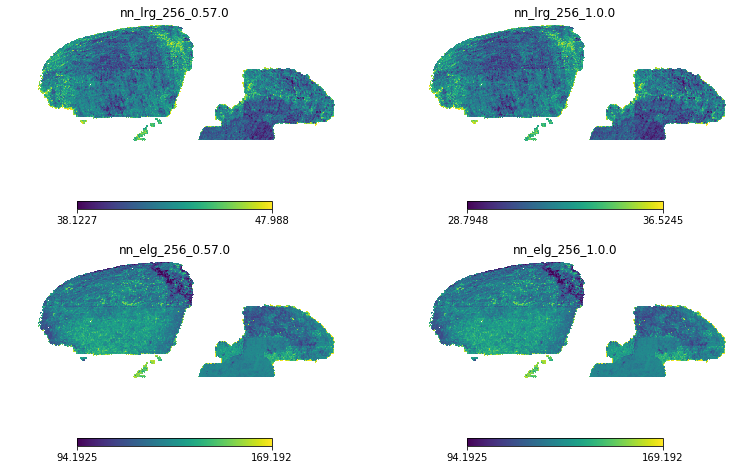

In [11]:
fg, ax = plt.subplots(ncols=2, nrows=2, figsize=(14, 8))
fg.subplots_adjust(wspace=0.0)
ax = ax.flatten()


for i, (title, sel) in enumerate(maps.items()):
    
    plt.sca(ax[i])
    hp.mollview(sel, rot=(120, ), hold=True, title=title, badcolor='w')

In [12]:
for i, (title, sel) in enumerate(maps.items()):
    filename = f'selection_{title}.npy'
    np.save(filename, sel, allow_pickle=False)
    print(f'wrote {filename}')

wrote selection_nn_lrg_256_0.57.0.npy
wrote selection_nn_lrg_256_1.0.0.npy
wrote selection_nn_elg_256_0.57.0.npy
wrote selection_nn_elg_256_1.0.0.npy


## Reading

In [13]:
lrg_ = np.load('selection_nn_lrg_256_0.57.0.npy')

In [14]:
lrg_

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

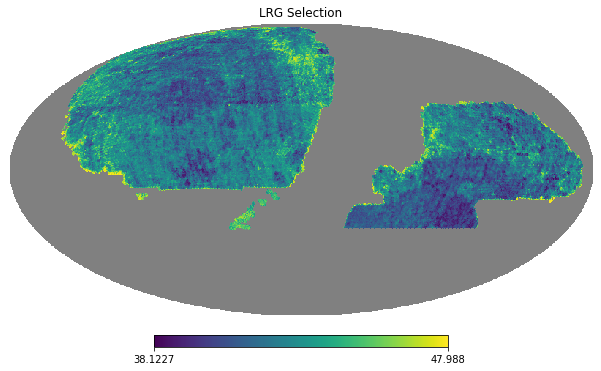

In [15]:
hp.mollview(lrg_, title='LRG Selection', rot=120)

In [3]:
import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
import lssutils.dataviz as dv

In [4]:
dv.setup_color()

In [11]:
maps = []
np.random.seed(42)
for i, el in enumerate([0, 1, 2, 3, 10, 100]):
    cl_ = np.zeros(101)
    cl_[el] = 1
    maps.append(hp.synfast(cl_, 256))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


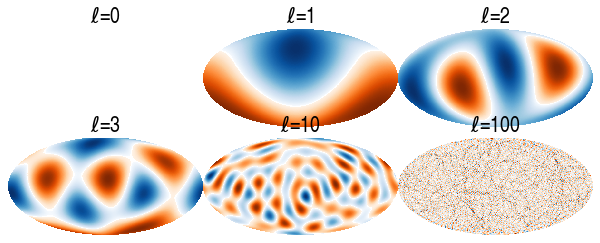

In [12]:
fg, ax = plt.subplots(ncols=3, nrows=2, figsize=(10.5, 4))
ax = ax.flatten()
fg.subplots_adjust(wspace=0, hspace=0)

for i, el in enumerate([0, 1, 2, 3, 10, 100]):
    plt.sca(ax[i])
    hp.mollview(maps[i], hold=True, 
                title=fr'$\ell$={el}', cbar=False, rot=-100,
                cmap=dv.mycolor())

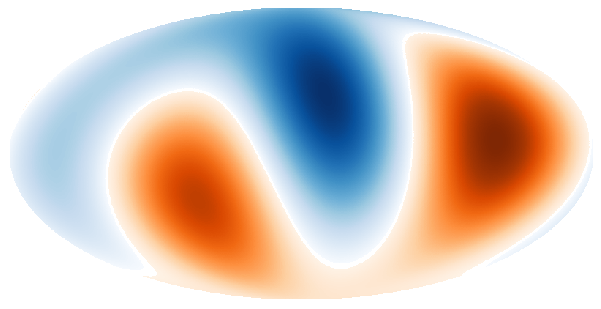

In [17]:
hp.mollview(np.sum(maps[:3], axis=0), rot=-100, cbar=False, title='',
           cmap=dv.mycolor())

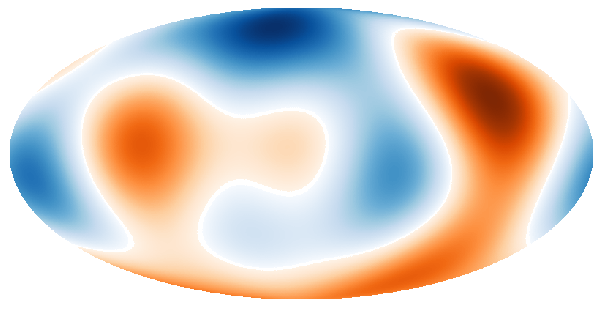

In [18]:
hp.mollview(np.sum(maps[:4], axis=0), rot=-100, cbar=False, title='',
           cmap=dv.mycolor())

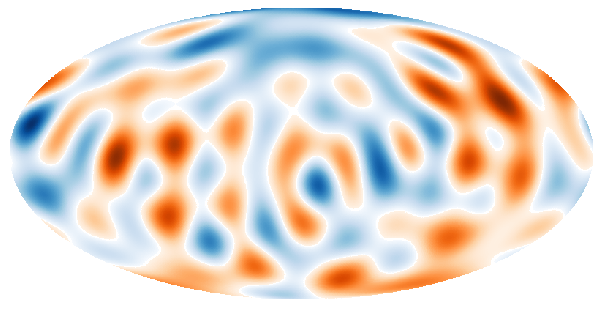

In [19]:
hp.mollview(np.sum(maps[:5], axis=0), rot=-100, cbar=False, title='',
           cmap=dv.mycolor())

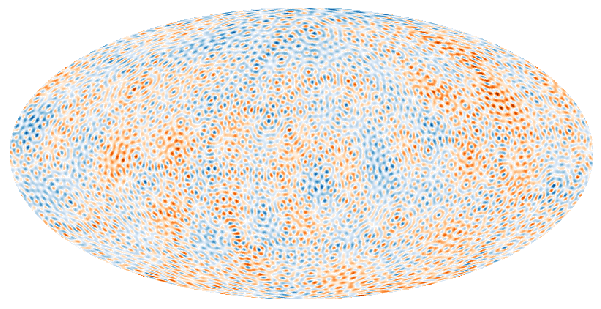

In [22]:
hp.mollview(np.sum(maps[:6], axis=0), rot=-100, cbar=False, title='',
           cmap=dv.mycolor())

In [5]:
el = np.arange(3*512)
cl = el**2*np.exp(-1*el**0.45)*1.0e-7

np.random.seed(42)
map1 = hp.synfast(cl, 256)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/users/PHS0336/medirz90/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/sphtfunc.py:395: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  warnings.warn(


(1e-14, 1e-05)

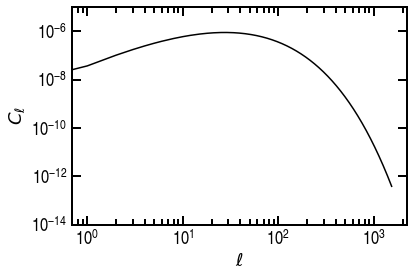

In [5]:
plt.plot(cl)

plt.xscale('log') #, linthreshx=1)
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.0e-14, 1.0e-5)

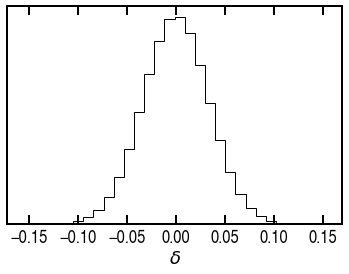

In [6]:
plt.hist(map1, histtype='step', bins=30)
plt.xlabel(r'$\delta$')
plt.yticks([])
_ = plt.xticks(np.arange(-0.15, 0.2, 0.05))

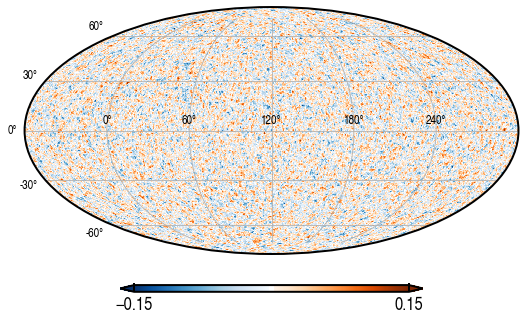

In [7]:
dv.mollview(map1, -0.15, 0.15, '', cmap=dv.mycolor(), colorbar=True,
           galaxy=False)

(1e-14, 1e-05)

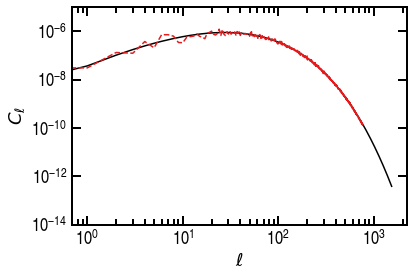

In [6]:
cl_obs = hp.anafast(map1)

plt.loglog(cl)
plt.loglog(cl_obs)

plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.0e-14, 1.0e-5)

In [7]:
## ELGs
elg_ = np.load('selection_nn_elg_256_0.57.0.npy')
is_bad = elg_ == hp.UNSEEN

map2 = map1.copy()
map2[is_bad] = np.nan

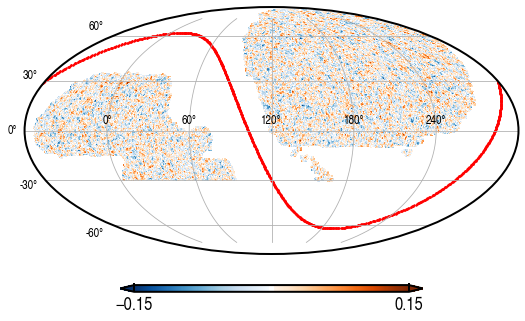

In [10]:
dv.mollview(map2, -0.15, 0.15, '', cmap=dv.mycolor(), colorbar=True,
           galaxy=True)

In [8]:
map2[is_bad] = hp.UNSEEN
cl_obs2 = hp.anafast(map2)

(1e-14, 1e-05)

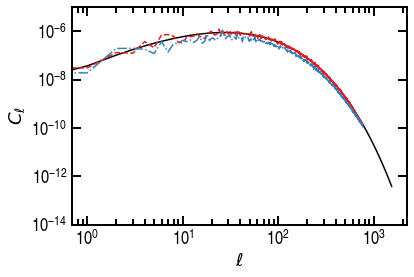

In [9]:
plt.plot(cl)
plt.plot(cl_obs)
plt.plot(cl_obs2/is_bad.mean())


plt.loglog()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.0e-14, 1.0e-5)

In [10]:
sel = elg_ / elg_[~is_bad].mean()
# plt.hist(sel[~is_bad], bins=24)

In [62]:
map3 = map1 * sel + 0.1*(sel - 1)
# map3 *= map1[~is_bad].sum() / map3[~is_bad].sum()

In [63]:
map3[is_bad] = np.nan

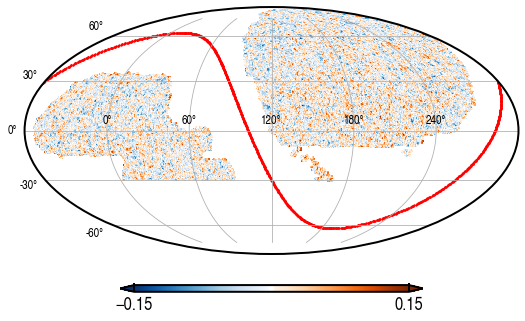

In [64]:
dv.mollview(map3, -0.15, 0.15, '', cmap=dv.mycolor(), colorbar=True,
           galaxy=True)

In [65]:
map3[is_bad] = hp.UNSEEN

In [66]:
cl_obs3 = hp.anafast(map3)

(1e-14, 1e-05)

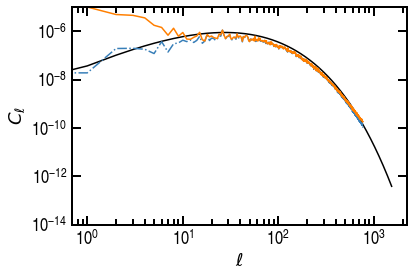

In [70]:
plt.plot(cl)
# plt.plot(cl_obs)
plt.plot(cl_obs2/is_bad.mean(), 'C2-.')
plt.plot(cl_obs3/is_bad.mean(), 'C3-')


plt.loglog()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')
plt.ylim(1.0e-14, 1.0e-5)